In [1]:
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml
import datetime
import sys
from tqdm import tqdm
import os
import random
import pickle
from glob import glob
import gc
from multiprocessing import Pool, cpu_count

import warnings
warnings.filterwarnings('ignore')

sys.path.append('/kaggle')
from utils.xgb import fit_xgb, inference_xgb
from utils.metric import compute_comptetition_metric
from utils.feature_contena import Features
from utils.pandas_utils import reduce_mem_usage

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
config = f"""
execution:
    exp_id: exp_042
    debug: False
    submit: False
    multiprocessing: True

dataset: 
    competition_dir: /kaggle/input/child-mind-institute-detect-sleep-states
    cv_split_path: /kaggle/input/cv_split/train_folds.csv
    train_base_path: /kaggle/input/train_base/train_base.csv
    step_csv_dir: /kaggle/input/save_series_csv/csvs
    3rd_stage_exp: exp_041
    2nd_stage_exp: exp_036

feature:
    agg_freq: 24 # [step]

xgboost:    
    objective: "reg:squarederror"
    learning_rate: 0.01  # 0.01で固定。学習時間とのトレードオフ
    reg_alpha: 0.02  # L1正則化。0.1が推奨。
    reg_lambda: 0.2  # L2正則化。0.1が推奨
    random_state: 42
    max_depth: 7  # 3-8。7くらいでいい。
    colsample_bytree: 0.5  # カラムが多い時は少なめ(0.4とか)にする。
    tree_method: "gpu_hist"
    
seed: 46
"""

CFG = yaml.load(config, Loader=yaml.SafeLoader)

CFG["output_dir"] = f"/kaggle/output/{CFG['execution']['exp_id']}"
os.makedirs(CFG["output_dir"], exist_ok=True)

In [3]:
sub = pd.read_csv(f'/kaggle/output/{CFG["dataset"]["3rd_stage_exp"]}/oof.csv')
oof = pd.read_csv(f'/kaggle/output/{CFG["dataset"]["2nd_stage_exp"]}/oof.csv')
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
display(sub.head())
display(oof.head())
display(labels.head())

,step,sub_step_before_modify,raw_step,series_id,score,event,oof_stage2,oof_stage3,target,minutes
0,4995,5015.0,5027.5,038441c925bb,0.868351,onset,0.152667,-19.312483,-23.0,1737.5
1,10933,10919.0,10931.5,038441c925bb,0.812971,wakeup,0.298439,14.026193,13.0,2457.5
2,20320,20399.0,20411.5,038441c925bb,0.575121,onset,0.191393,-78.707001,-155.0,3057.5
3,23990,23975.0,23987.5,038441c925bb,-0.095061,wakeup,0.745363,15.971451,0.0,2937.5
4,24075,24047.0,24059.5,038441c925bb,0.181708,onset,0.474507,28.673332,0.0,3297.5


,target,step,series_id,fold,oof_stage1,STAGE_stage1,raw_oof,oof_stage2,STAGE_stage2,minutes,oof
0,1,11.5,038441c925bb,2,NaN,2,0.999819,NaN,NaN,NaN,NaN
1,1,35.5,038441c925bb,2,NaN,2,0.999644,NaN,NaN,NaN,NaN
2,1,59.5,038441c925bb,2,NaN,2,0.993865,NaN,NaN,NaN,NaN
3,1,83.5,038441c925bb,2,NaN,2,0.995005,NaN,NaN,NaN,NaN
4,1,107.5,038441c925bb,2,NaN,2,0.994551,NaN,NaN,NaN,NaN


,series_id,night,event,step,timestamp
0,038441c925bb,1,onset,4992.0,2018-08-14T22:26:00-0400
1,038441c925bb,1,wakeup,10932.0,2018-08-15T06:41:00-0400
2,038441c925bb,2,onset,20244.0,2018-08-15T19:37:00-0400
3,038441c925bb,2,wakeup,27492.0,2018-08-16T05:41:00-0400
4,038441c925bb,3,onset,39996.0,2018-08-16T23:03:00-0400


## 周辺に予測を撒く

In [4]:
dfs = []
for level, diff in enumerate([0, -5, 5, -15, 15, -30, 30]):
    tmp = sub.copy()
    tmp["level"] = level
    tmp["step"] += CFG["feature"]["agg_freq"] * diff
    tmp["raw_step"] += CFG["feature"]["agg_freq"] * diff
    tmp["sub_step_before_modify"] += CFG["feature"]["agg_freq"] * diff
    dfs.append(tmp)
sub = pd.concat(dfs, axis=0).reset_index(drop=True)
sub.sort_values(["series_id", "step", "level"], inplace=True)
sub = sub.drop_duplicates(["series_id", "step"], keep="first").reset_index(drop=True)
sub

,step,sub_step_before_modify,raw_step,series_id,score,event,oof_stage2,oof_stage3,target,minutes,level
0,4275,4295.0,4307.5,038441c925bb,0.868351,onset,0.152667,-19.312483,-23.0,1737.5,5
1,4635,4655.0,4667.5,038441c925bb,0.868351,onset,0.152667,-19.312483,-23.0,1737.5,3
2,4875,4895.0,4907.5,038441c925bb,0.868351,onset,0.152667,-19.312483,-23.0,1737.5,1
3,4995,5015.0,5027.5,038441c925bb,0.868351,onset,0.152667,-19.312483,-23.0,1737.5,0
4,5115,5135.0,5147.5,038441c925bb,0.868351,onset,0.152667,-19.312483,-23.0,1737.5,2
...,...,...,...,...,...,...,...,...,...,...,...
74812,581554,581567.0,581579.5,fe90110788d2,0.800698,wakeup,0.441357,-12.889473,-83.0,1497.5,1
74813,581674,581687.0,581699.5,fe90110788d2,0.800698,wakeup,0.441357,-12.889473,-83.0,1497.5,0
74814,581794,581807.0,581819.5,fe90110788d2,0.800698,wakeup,0.441357,-12.889473,-83.0,1497.5,2
74815,582034,582047.0,582059.5,fe90110788d2,0.800698,wakeup,0.441357,-12.889473,-83.0,1497.5,4


## 正解ラベルを作成

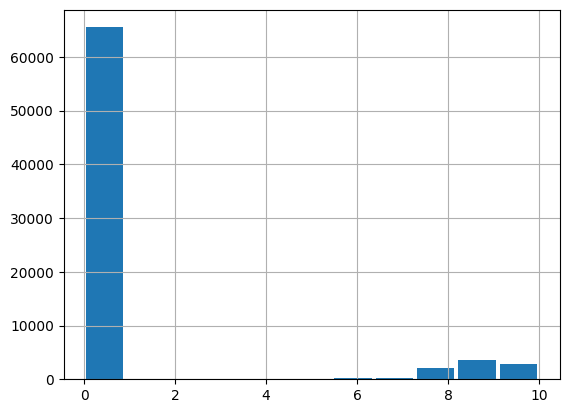

series_id                 5331385
step                      5331385
fold                      5331385
raw_oof                   5331385
minutes                    692843
target                      74793
sub_step                    74793
raw_step                    74793
sub_step_before_modify      74793
event                       74793
level                       74793
score                       74793
oof_stage3                  74793
dtype: int64

In [5]:
thresholds = [12, 36, 60, 90, 120, 150, 180, 240, 300, 360]
dfs = []
for (series_id, event), label_df in labels.groupby(["series_id", "event"]):
    sub_df = sub[(sub["series_id"] == series_id) & (sub["event"] == event)].reset_index(drop=True)
    targets = np.zeros(len(sub_df))
    for thresh in thresholds:
        matched = np.zeros(len(sub_df), dtype=bool)
        for step in label_df["step"].values:
            min_dist = thresh
            min_idx = -1            
            for idx, sub_step in enumerate(sub_df["step"].values):
                if matched[idx]:
                    continue
                dist = abs(step - sub_step)
                if dist < min_dist:
                    min_dist = dist
                    min_idx = idx
            if min_idx != -1:
                targets[min_idx] += 1
                matched[min_idx] = True
    sub_df["target"] = targets
    sub_df["sub_step"] = sub_df["step"].values
    dfs.append(sub_df)
sub = pd.concat(dfs).reset_index(drop=True)
plt.hist(sub["target"].values, bins=11, rwidth=0.9)
plt.grid()
plt.show()

oof = oof[["series_id", "step", "fold", "raw_oof", "minutes"]].merge(
    sub[["target", "series_id", 
         "sub_step", "raw_step", "sub_step_before_modify",
         "event", "level", "score", "oof_stage3"]], 
    left_on=["series_id", "step"], 
    right_on=["series_id", "raw_step"], 
    how="left",
    )
(~oof.isna()).sum()

In [6]:
(oof.target ** 2).mean() ** 0.5

3.143861659997996

In [7]:
oof.head()

,series_id,step,fold,raw_oof,minutes,target,sub_step,raw_step,sub_step_before_modify,event,level,score,oof_stage3
0,038441c925bb,11.5,2,0.999819,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,038441c925bb,35.5,2,0.999644,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,038441c925bb,59.5,2,0.993865,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,038441c925bb,83.5,2,0.995005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,038441c925bb,107.5,2,0.994551,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 特徴生成

In [8]:
def generate_features(train: pd.DataFrame):
    features = Features()
    features.add_num_features(["level", "score"])

    # 時刻
    train["total_seconds"] = train.index * 5 *  CFG["feature"]["agg_freq"] % (24 * 60 * 60)
    features.add_num_feature("total_seconds")    

    # 分
    features.add_num_feature("minutes")

    # gap
    train["sub_gap"] = train["sub_step"] - train["step"]
    train["sub_minutes"] = (train["minutes"] + train["sub_gap"] * 12) % (60 * 60)
    train["before_gap"] = train["sub_step_before_modify"] - train["step"]
    train["before_minutes"] = (train["minutes"] + train["before_gap"] * 12) % (60 * 60)
    features.add_num_features(["sub_gap", "sub_minutes", "before_gap", "before_minutes", "oof_stage3"])

    columns = ["raw_oof"]

    # その人のその時刻での平均的な測定値
    gb = train.groupby("total_seconds")[columns].mean()
    gb.columns = [f"{c}_mean" for c in columns]
    train["raw_oof_mean"] = train["total_seconds"].map(gb["raw_oof_mean"])
    features.add_num_features(gb.columns.tolist())

    # diff
    f_names = [f"{c}_diff_abs" for c in columns]
    train[f_names] = train[columns].diff().abs()
    features.add_num_features(f_names)

    # 予測対象か
    train["for_pred"] = train["target"].notna().astype(float)

    columns += f_names
    columns += gb.columns.tolist()
    columns += ["for_pred"]

    # rolling
    dts = [1, 2, 3, 5, 10, 50]
    shift_features_dic = {}
    for dt in dts:       
        shift_features = []

        f_names = [f"{c}_rolling_mean_{dt}" for c in columns]
        train[f_names] = train[columns].rolling(dt, center=True).mean()
        features.add_num_features(f_names)
        shift_features += f_names

        f_names = [f"{c}_rolling_std_{dt}" for c in columns]
        train[f_names] = train[columns].rolling(dt, center=True).std()
        features.add_num_features(f_names)
        shift_features += f_names

        f_names = [f"{c}_rolling_max_{dt}" for c in columns]
        train[f_names] = train[columns].rolling(dt, center=True).max()
        features.add_num_features(f_names)
        shift_features += f_names

        f_names = [f"{c}_rolling_min_{dt}" for c in columns]
        train[f_names] = train[columns].rolling(dt, center=True).min()
        features.add_num_features(f_names)
        shift_features += f_names

        f_names = [f"{c}_rolling_median_{dt}" for c in columns]
        train[f_names] = train[columns].rolling(dt, center=True).median()
        features.add_num_features(f_names)
        shift_features += f_names

        f_names = [f"{c}_rolling_square_mean_{dt}" for c in columns]
        train[f_names] = ((train[columns] ** 2).rolling(dt, center=True).mean())
        features.add_num_features(f_names)
        shift_features += f_names

        shift_features_dic[dt] = shift_features

    # shift
    for dt, shift_features in shift_features_dic.items():
        for c in [0.5, 1, 2]:
            _dt = int(dt * c)
            if _dt == 0:
                continue
            f_names_plus = [f"{c}_shift_{_dt}" for c in shift_features]
            train[f_names_plus] = train[shift_features].shift(_dt)
            features.add_num_features(f_names_plus)

            f_names_minus = [f"{c}_shift_{-_dt}" for c in shift_features]
            train[f_names_minus] = train[shift_features].shift(-_dt)
            features.add_num_features(f_names_minus)

            f_names_diff = [f"{c}_shift_{_dt}_diff" for c in shift_features]
            train[f_names_diff] = train[f_names_plus].values - train[f_names_minus].values
            features.add_num_features(f_names_diff)

    train = train.dropna(subset=["target"]).reset_index(drop=True)

    train = reduce_mem_usage(train)
    gc.collect()
    return train, features

def generate_features_for_group(group):
    _, df = group
    df, features = generate_features(df)
    return df, features

In [9]:
groups = list(oof.groupby("series_id"))

with Pool(30) as pool:
    results = list(tqdm(pool.imap(generate_features_for_group, groups), total=len(groups)))

dfs, features_list = zip(*results)
features = features_list[0]

100%|██████████| 277/277 [03:30<00:00,  1.32it/s]


In [10]:
train = pd.concat(dfs).reset_index(drop=True)
display(train.head())
print(train.shape)

,series_id,step,fold,raw_oof,minutes,target,sub_step,raw_step,sub_step_before_modify,event,...,raw_oof_mean_rolling_min_50_shift_100_diff,for_pred_rolling_min_50_shift_100_diff,raw_oof_rolling_median_50_shift_100_diff,raw_oof_diff_abs_rolling_median_50_shift_100_diff,raw_oof_mean_rolling_median_50_shift_100_diff,for_pred_rolling_median_50_shift_100_diff,raw_oof_rolling_square_mean_50_shift_100_diff,raw_oof_diff_abs_rolling_square_mean_50_shift_100_diff,raw_oof_mean_rolling_square_mean_50_shift_100_diff,for_pred_rolling_square_mean_50_shift_100_diff
0,038441c925bb,4307.5,2,0.999037,NaN,0.0,4275.0,4307.5,4295.0,onset,...,0.756376,0.0,0.961868,-0.002942,0.722211,0.0,0.998202,-0.000029,0.918541,0.0
1,038441c925bb,4667.5,2,0.998153,NaN,0.0,4635.0,4667.5,4655.0,onset,...,0.735159,0.0,0.963370,-0.003910,0.718233,0.0,0.998055,-0.000034,0.914382,0.0
2,038441c925bb,4907.5,2,0.961878,1137.5,0.0,4875.0,4907.5,4895.0,onset,...,0.700311,0.0,0.958695,-0.003865,0.712087,0.0,0.997373,-0.000039,0.904480,0.0
3,038441c925bb,5027.5,2,0.152667,1737.5,10.0,4995.0,5027.5,5015.0,onset,...,0.693796,0.0,0.951029,-0.004294,0.702255,0.0,0.996470,-0.000052,0.894397,0.0
4,038441c925bb,5147.5,2,0.074428,2337.5,0.0,5115.0,5147.5,5135.0,onset,...,0.691680,0.0,0.943986,-0.004287,0.691754,0.0,0.995224,-0.000060,0.884655,0.0


(74793, 1389)


In [11]:
train["bin_event"] = train["event"].map({"onset": 0.0, "wakeup": 1.0})
features.add_num_feature("bin_event")

## 学習

In [12]:
# 学習
trn_oof, models = fit_xgb(
    X=train, 
    y=train["target"], 
    folds=train["fold"].astype(int), 
    features=features.all_features(),
    params=CFG["xgboost"], 
    es_rounds=50
)
train["oof"] = trn_oof

# 保存
for i, model in enumerate(models):
    model.save_model(os.path.join(CFG["output_dir"], f'xgb_fold{i}.model'))

  0%|          | 0/5 [00:00<?, ?it/s]

== fold 0 ==
[0]	eval-rmse:3.03132
[50]	eval-rmse:2.35886
[100]	eval-rmse:2.04929
[150]	eval-rmse:1.91723
[200]	eval-rmse:1.86217
[250]	eval-rmse:1.83997
[300]	eval-rmse:1.83097
[350]	eval-rmse:1.82658
[400]	eval-rmse:1.82460
[450]	eval-rmse:1.82363
[500]	eval-rmse:1.82349
[524]	eval-rmse:1.82356


 20%|██        | 1/5 [00:11<00:46, 11.74s/it]

== fold 1 ==
[0]	eval-rmse:3.03635
[50]	eval-rmse:2.39943
[100]	eval-rmse:2.09682
[150]	eval-rmse:1.96108
[200]	eval-rmse:1.90062
[250]	eval-rmse:1.87329
[300]	eval-rmse:1.85995
[350]	eval-rmse:1.85287
[400]	eval-rmse:1.84978
[450]	eval-rmse:1.84789
[500]	eval-rmse:1.84650
[550]	eval-rmse:1.84505
[600]	eval-rmse:1.84429
[650]	eval-rmse:1.84415
[700]	eval-rmse:1.84371
[750]	eval-rmse:1.84317
[800]	eval-rmse:1.84270
[850]	eval-rmse:1.84250
[871]	eval-rmse:1.84249


 40%|████      | 2/5 [00:29<00:45, 15.02s/it]

== fold 2 ==
[0]	eval-rmse:2.99574
[50]	eval-rmse:2.38308
[100]	eval-rmse:2.11216
[150]	eval-rmse:2.00209
[200]	eval-rmse:1.95726
[250]	eval-rmse:1.93877
[300]	eval-rmse:1.93134
[350]	eval-rmse:1.92697
[400]	eval-rmse:1.92419
[450]	eval-rmse:1.92197
[500]	eval-rmse:1.92136
[550]	eval-rmse:1.92096
[600]	eval-rmse:1.92044
[650]	eval-rmse:1.91983
[700]	eval-rmse:1.91989
[750]	eval-rmse:1.91982
[767]	eval-rmse:1.91971


 60%|██████    | 3/5 [00:44<00:30, 15.01s/it]

== fold 3 ==
[0]	eval-rmse:2.90614
[50]	eval-rmse:2.29521
[100]	eval-rmse:2.02108
[150]	eval-rmse:1.90960
[200]	eval-rmse:1.86608
[250]	eval-rmse:1.85007
[300]	eval-rmse:1.84401
[350]	eval-rmse:1.84100
[400]	eval-rmse:1.84007
[450]	eval-rmse:1.83944
[500]	eval-rmse:1.83877
[541]	eval-rmse:1.83905


 80%|████████  | 4/5 [00:55<00:13, 13.41s/it]

== fold 4 ==
[0]	eval-rmse:2.97749
[50]	eval-rmse:2.34793
[100]	eval-rmse:2.07077
[150]	eval-rmse:1.96200
[200]	eval-rmse:1.92252
[250]	eval-rmse:1.90932
[300]	eval-rmse:1.90522
[350]	eval-rmse:1.90384
[400]	eval-rmse:1.90426
[407]	eval-rmse:1.90437


100%|██████████| 5/5 [01:04<00:00, 12.81s/it]


In [13]:
train["score"] = train["oof"]
train["raw_step"] = train["step"]
train["step"] = train["sub_step"].astype(int)
sub = train[["score", "raw_step", "step", "event", "level", "series_id"]]
sub.to_csv(os.path.join(CFG["output_dir"], "submission.csv"), index=False)

In [14]:
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
score, ap_table = compute_comptetition_metric(labels, sub)
print(f"score: {score:.4f}")
display(ap_table)

score: 0.7270


event   tolerance
onset   12           0.138386
        36           0.516118
        60           0.714883
        90           0.777209
        120          0.809296
        150          0.825974
        180          0.838978
        240          0.848150
        300          0.857924
        360          0.866156
wakeup  12           0.144800
        36           0.529032
        60           0.729916
        90           0.790391
        120          0.823041
        150          0.838234
        180          0.850969
        240          0.867204
        300          0.881913
        360          0.890792
dtype: float64

In [15]:
sub

,score,raw_step,step,event,level,series_id
0,0.033546,4307.5,4275,onset,5.0,038441c925bb
1,0.014175,4667.5,4635,onset,3.0,038441c925bb
2,0.066006,4907.5,4875,onset,1.0,038441c925bb
3,8.673751,5027.5,4995,onset,0.0,038441c925bb
4,0.209272,5147.5,5115,onset,2.0,038441c925bb
...,...,...,...,...,...,...
74788,5.273878,581579.5,581554,wakeup,1.0,fe90110788d2
74789,1.877089,581699.5,581674,wakeup,0.0,fe90110788d2
74790,2.506968,581819.5,581794,wakeup,2.0,fe90110788d2
74791,0.130344,582059.5,582034,wakeup,4.0,fe90110788d2
